In [12]:
import tensorflow as tf
from tensorflow import keras

import os

base_dir = "cats_and_dogs_filtered"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

validation_cats_fnames = os.listdir(validation_cats_dir)
validation_dogs_fnames = os.listdir(validation_dogs_dir)

# Building a Small Model from Scratch to get to ~72% Accuracy

model = keras.models.Sequential(
    [keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')]
)

model.summary()

from keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Data Preprocessing

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150, 150)
)

# Training

history = model.fit(
    train_generator, epochs=1, validation_data = validation_generator, verbose=2
)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 17, 17, 64)      

1/1 [==============================] - 0s 57ms/step


/tmp/ipykernel_3008/3077315183.py:44: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


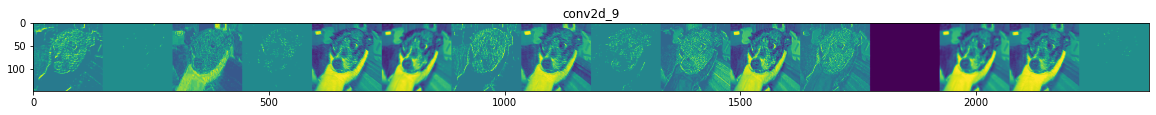

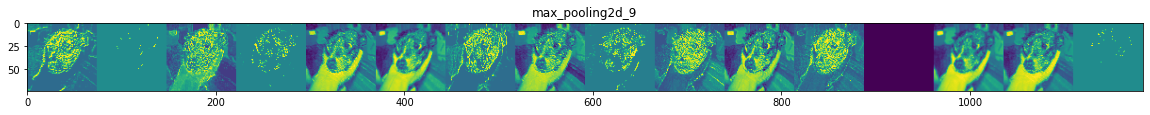

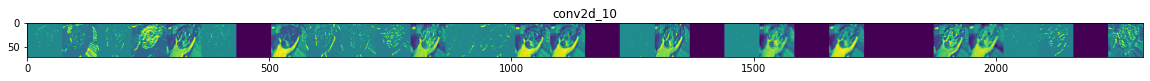

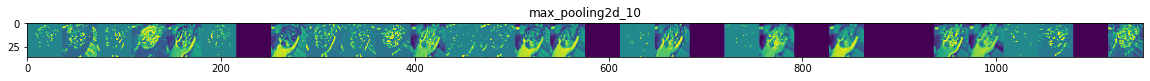

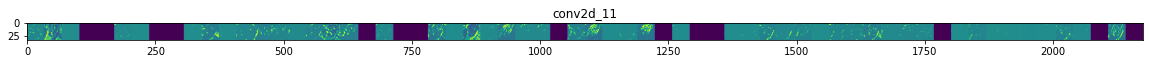

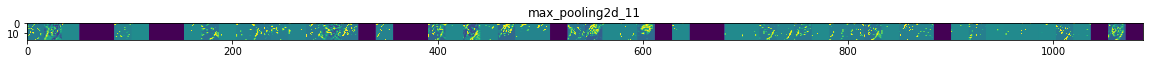

In [14]:
import numpy as np
import random
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

# Define a new Model that will take an image as input, and will output
# intermediate representation for all layers in the previous model

successive_outputs = [layer.output for layer in model.layers]
visualization_model = keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.add
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cats_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dogs_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representation for this image.

successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representation

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    
    if len(feature_map.shape) == 4:

        n_features = feature_map.shape[-1] # number of features in the feature map
        size = feature_map.shape[1] # feature map shape **(1, size, size, n_features)**

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        # Display the grid

        scale = 20. / n_features
        plt.figure(figsize = (scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')